# Q-CTRL Quantum Coalition Hack (QCHack) 2021 Challenge

Full details are here: https://docs.q-ctrl.com/boulder-opal/application-notes/q-ctrl-qchack-challenge.

In order to run this notebook locally, you will need to sign up for an account through Q-CTRL and install the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

In [2]:
# Define standard deviation of the errors in the experimental results.
sigma = 0.01

# Shorter duration means faster gate times
duration = 60 # ns

# Define the number of test points obtained per run.
test_point_count = 20

# Define number of segments in the control.
segment_count = 8

shot_count = 1024

In [3]:
def obtain_initial_results():
    # Define parameters as a set of controls with piecewise constant segments.
    parameter_set = (
        np.pi
        / duration
        * (np.linspace(-1, 1, test_point_count)[:, None])
        * np.ones((test_point_count, segment_count))
    )

    controls = []
    for k in range(len(parameter_set)):
        controls.append({"duration": duration, "values": parameter_set[k]})

    # Obtain a set of initial experimental results.
    experiment_results = qctrl.functions.calculate_qchack_measurements(
            controls=controls,
            shot_count=shot_count,
        )
    
    return (experiment_results, parameter_set)

In [4]:
def optimize_gate(experiment_results, parameter_set, cost_function):
    # Define initialization object for the automated closed-loop optimization.
    length_scale_bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
        lower_bound=1e-5,
        upper_bound=1e5,
    )
    bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
        lower_bound=-5 * np.pi / duration,
        upper_bound=5 * np.pi / duration,
    )
    initializer = qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer(
        length_scale_bounds=[length_scale_bound] * segment_count,
        bounds=[bound] * segment_count,
        rng_seed=0,
    )

    # Define state object for the closed-loop optimization.
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        gaussian_process_initializer=initializer,
    )
    
    best_cost, best_controls = min(
        zip(cost_function(experiment_results), parameter_set), key=lambda params: params[0]
    )
    optimization_count = 0

    # Run the optimization loop until the cost (infidelity) is sufficiently small.
    while best_cost > 3*sigma:
        # Print the current best cost.
        optimization_steps = (
            "optimization step" if optimization_count == 1 else "optimization steps"
        )
        print(
            f"Best infidelity after {optimization_count} BOULDER OPAL {optimization_steps}: {best_cost}"
        )

        # Organize the experiment results into the proper input format.
        results = [
            qctrl.types.closed_loop_optimization_step.CostFunctionResult(
                parameters=list(parameters),
                cost=cost,
                cost_uncertainty=sigma,
            )
            for parameters, cost in zip(parameter_set, cost_function(experiment_results))
        ]

        # Call the automated closed-loop optimizer and obtain the next set of test points.
        optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
            optimizer=optimizer,
            results=results,
            test_point_count=test_point_count,
        )
        optimization_count += 1

        # Organize the data returned by the automated closed-loop optimizer.
        parameter_set = np.array(
            [test_point.parameters for test_point in optimization_result.test_points]
        )
        optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
            state=optimization_result.state
        )

        controls = []
        for k in range(len(parameter_set)):
            controls.append({"duration": duration, "values": parameter_set[k]})

        # Obtain experiment results that the automated closed-loop optimizer requested.
        experiment_results = qctrl.functions.calculate_qchack_measurements(
            controls=controls,
            shot_count=shot_count,
        )

        # Record the best results after this round of experiments.
        cost, controls = min(
            zip(cost_function(experiment_results), parameter_set), key=lambda params: params[0]
        )
        if cost < best_cost:
            best_cost = cost
            best_controls = controls

    # Print final best cost.
    print(f"Infidelity: {best_cost}")

    # Plot controls that correspond to the best cost.
    plot_controls(
        figure=plt.figure(),
        controls={
            r"$\Omega(t)$": [
                {"duration": duration / len(best_controls), "value": value}
                for value in best_controls
            ]
        },
    )
    
    return best_controls

In [5]:
import jsonpickle.ext.numpy as jsonpickle_numpy
jsonpickle_numpy.register_handlers()
import jsonpickle
import numpy as np

In [6]:
def get_infidelities_xgate(experiment_results):
    measurements = experiment_results.measurements
    infidelities = []
    for k in range(len(measurements)):
        infidelity = 1.0 - (measurements[k].count(1) / shot_count);
        infidelities.append(infidelity)
    return infidelities

In [7]:
# These initial results are usually pretty bad
(initial_results, parameter_set) = obtain_initial_results()
with np.printoptions(precision=3, linewidth=140):
    print(np.array(get_infidelities_xgate(initial_results)))

  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_qchack_measurements is currently in a queue waiting to be processed.


100%|██████████| 100/100 [00:02<00:00, 42.12it/s]

[0.935 0.938 0.951 0.948 0.963 0.979 0.98  0.984 0.989 0.985 0.98  0.989 0.991 0.982 0.974 0.977 0.964 0.95  0.931 0.932]


Best infidelity after 0 BOULDER OPAL optimization steps: 0.9306640625


  0%|          | 0/100 [00:02<?, ?it/s]

Your task calculate_closed_loop_optimization_step is currently in a queue waiting to be processed.


100%|██████████| 100/100 [00:04<00:00, 22.83it/s]


Your task calculate_closed_loop_optimization_step has started.


100%|██████████| 100/100 [00:02<00:00, 42.19it/s]


Best infidelity after 1 BOULDER OPAL optimization step: 0.833984375


100%|██████████| 100/100 [00:02<00:00, 42.13it/s]


Best infidelity after 2 BOULDER OPAL optimization steps: 0.6611328125


100%|██████████| 100/100 [00:02<00:00, 42.20it/s]


Best infidelity after 3 BOULDER OPAL optimization steps: 0.4091796875


100%|██████████| 100/100 [00:02<00:00, 42.05it/s]


Best infidelity after 4 BOULDER OPAL optimization steps: 0.19140625


100%|██████████| 100/100 [00:02<00:00, 42.20it/s]


Best infidelity after 5 BOULDER OPAL optimization steps: 0.1806640625


100%|██████████| 100/100 [00:02<00:00, 41.92it/s]


Best infidelity after 6 BOULDER OPAL optimization steps: 0.162109375


100%|██████████| 100/100 [00:02<00:00, 42.24it/s]


Best infidelity after 7 BOULDER OPAL optimization steps: 0.1328125


100%|██████████| 100/100 [00:02<00:00, 42.15it/s]


Infidelity: 0.02734375


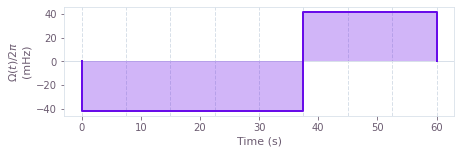

In [8]:
x_gate_control = optimize_gate(initial_results, parameter_set, get_infidelities_xgate)
not_control = {"duration": duration, "value": x_gate_control}
json_not_control = jsonpickle.encode(not_control)
with open('not_gate_pulse.json', 'w') as file:
    file.write(json_not_control)

In [9]:
# Obtain and print the final results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=[{'duration': duration, 'values': x_gate_control}],
    shot_count=shot_count,
)

measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

100%|██████████| 100/100 [00:02<00:00, 45.58it/s]

control #0: P(|0>) = 0.03, P(|1>) = 0.97, P(|2>) = 0.00


In [10]:
def get_infidelities_hgate(experiment_results):
    measurements = experiment_results.measurements
    infidelities = []
    for k in range(len(measurements)):
        infidelity = abs(measurements[k].count(0) - measurements[k].count(1)) / shot_count
        infidelities.append(infidelity)
    return infidelities

In [11]:
# These initial results are usually pretty bad
(initial_results, parameter_set) = obtain_initial_results()
with np.printoptions(precision=3, linewidth=140):
    print(np.array(get_infidelities_hgate(initial_results)))

100%|██████████| 100/100 [00:02<00:00, 42.23it/s]

[0.844 0.854 0.893 0.908 0.934 0.934 0.959 0.953 0.973 0.973 0.982 0.994 0.957 0.971 0.953 0.924 0.922 0.9   0.871 0.854]


Best infidelity after 0 BOULDER OPAL optimization steps: 0.84375


100%|██████████| 100/100 [00:02<00:00, 41.99it/s]


Best infidelity after 1 BOULDER OPAL optimization step: 0.64453125


100%|██████████| 100/100 [00:02<00:00, 42.09it/s]


Best infidelity after 2 BOULDER OPAL optimization steps: 0.173828125


100%|██████████| 100/100 [00:02<00:00, 41.94it/s]


Best infidelity after 3 BOULDER OPAL optimization steps: 0.0546875


100%|██████████| 100/100 [00:02<00:00, 42.22it/s]


Best infidelity after 4 BOULDER OPAL optimization steps: 0.0546875


100%|██████████| 100/100 [00:02<00:00, 42.07it/s]


Best infidelity after 5 BOULDER OPAL optimization steps: 0.0546875


100%|██████████| 100/100 [00:02<00:00, 42.02it/s]


Infidelity: 0.0


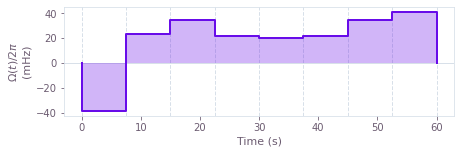

In [12]:
h_gate_control = optimize_gate(initial_results, parameter_set, get_infidelities_hgate)
h_control = {"duration": duration, "value": h_gate_control}
json_not_control = jsonpickle.encode(h_control)
with open('h_gate_pulse.json', 'w') as file:
    file.write(json_not_control)

In [13]:
# Obtain and print the final results of the experiment.
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=[{'duration': duration, 'values': h_gate_control}],
    shot_count=shot_count,
)

measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

100%|██████████| 100/100 [00:02<00:00, 45.56it/s]

control #0: P(|0>) = 0.51, P(|1>) = 0.49, P(|2>) = 0.00


In [15]:
# Try now with multiple repetitions to see how error increases
repetitions = [1, 4, 16, 32, 64]
controls = []

for repetition_count in repetitions:
    controls.append({"duration": duration, "values": h_gate_control, "repetition_count": repetition_count})

experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
    )

for repetition_count, measurement_counts in zip(repetitions, experiment_results.measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"With {repetition_count:2d} repetitions: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

100%|██████████| 100/100 [00:02<00:00, 44.87it/s]

With  1 repetitions: P(|0>) = 0.50, P(|1>) = 0.50, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.55, P(|1>) = 0.45, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.70, P(|1>) = 0.30, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 0.34, P(|1>) = 0.66, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 0.90, P(|1>) = 0.10, P(|2>) = 0.00
